In [1]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import datetime
import sys
from time import time
from datetime import datetime, date
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV


In [2]:
#Загрузка данных
data = pd.read_csv('/media/sf_helicopter_connection/Video_Games_Sales_as_at_22_Dec_2016_csv/Video_Games_Sales_as_at_22_Dec_2016.csv')

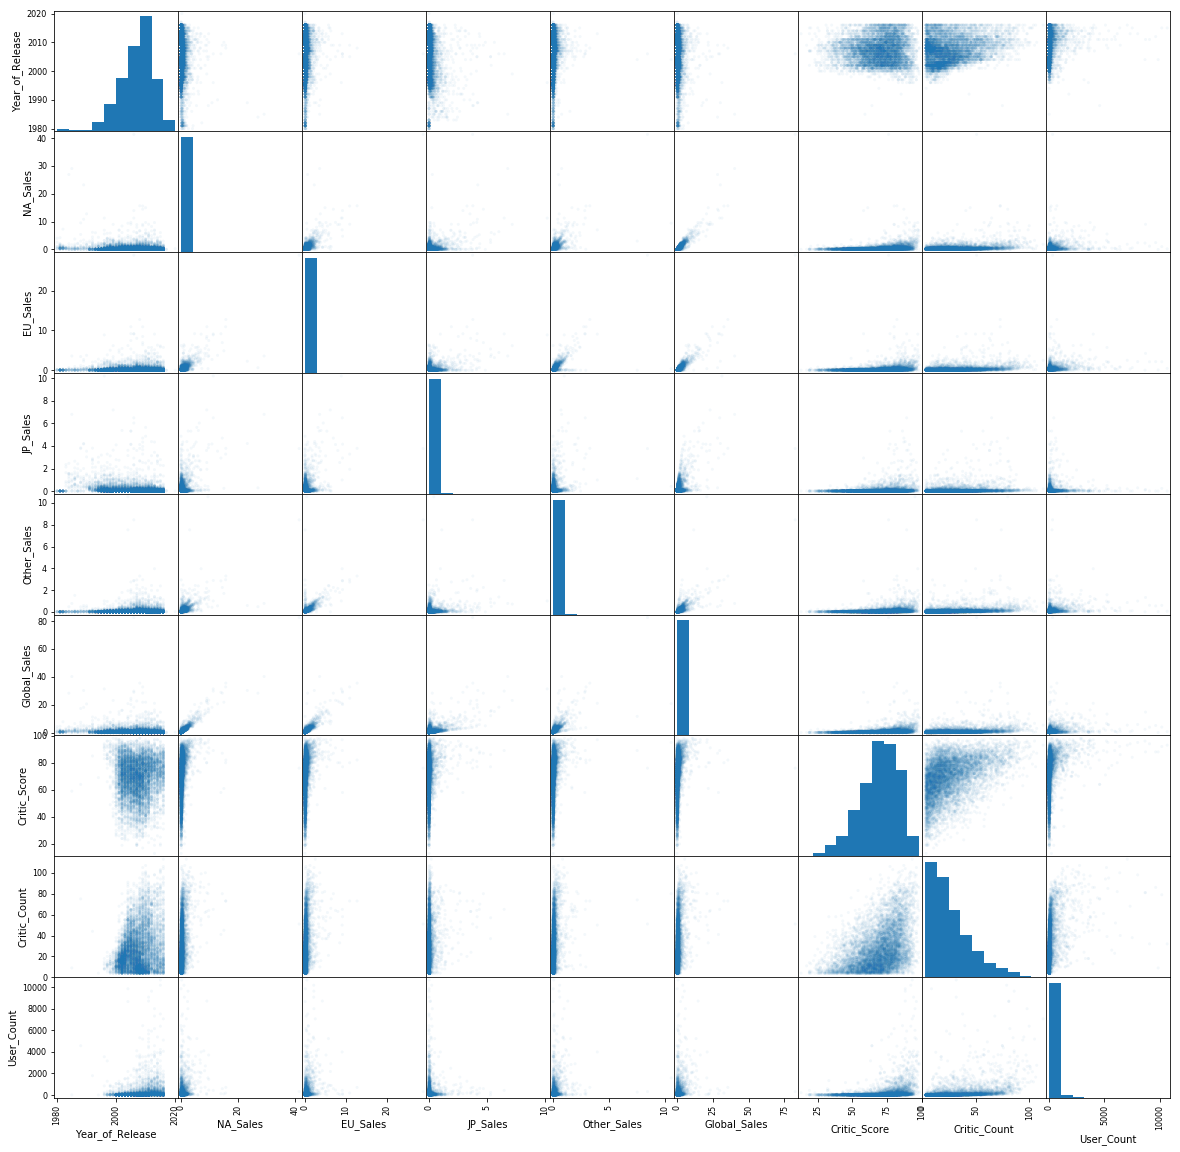

In [3]:
#Гистограммы признаков
hist = pd.plotting.scatter_matrix(data, alpha=0.05, figsize=(20,20))

In [4]:
#Данные перед обработкой
data.count(axis=0)

Name               16717
Platform           16719
Year_of_Release    16450
Genre              16717
Publisher          16665
NA_Sales           16719
EU_Sales           16719
JP_Sales           16719
Other_Sales        16719
Global_Sales       16719
Critic_Score        8137
Critic_Count        8137
User_Score         10015
User_Count          7590
Developer          10096
Rating              9950
dtype: int64

In [5]:
#Отбрасывание данных с пустыми значениями 'Name' и 'Publisher'
data = data.dropna(axis=0, subset=['Name'])
data = data.dropna(axis=0, subset=['Publisher'])

In [6]:
#Извлечение уникальных значений жанров и создание списка
gen = []
for i in pd.unique(data['Genre']):
    gen.append(i)

In [7]:
#Разделение данных на категориальные и численные
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object']

#Замена nan значений year_of_release на медианные
for genre in gen:
    temp = data.loc[(data['Genre'] == genre), 'Year_of_Release']
    data.loc[(data['Genre'] == genre), 'Year_of_Release'] = data.loc[(data['Genre'] == genre), 
                                                                     'Year_of_Release'].fillna(temp.median(axis=0), axis=0)
#Замена nan значений numerical_columns на медианные
for i in numerical_columns:
    if i == 'Year_of_Release':
        continue
    data[i] = data[i].fillna(data[i].median(axis=0), axis=0)

In [8]:
#Преобразование string чисел numerical_data во float и прочих string данных в nan
#прочие string данные имеют вид 'tbd'
for index, value in data['User_Score'].items():
    if value != None:
        try:
            data.loc[index, 'User_Score'] = float(value)
        except ValueError:
            data.loc[index, 'User_Score'] = np.nan
    else:
        continue
#Замена nan значений на медиинные
data['User_Score'] = data['User_Score'].fillna(data['User_Score'].median(axis=0), axis=0)

In [9]:
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object']

In [10]:
del data['Developer']
data_describe = data.describe(include=[object])
data['Rating'] = data['Rating'].fillna(data_describe['Rating']['top'])

In [11]:
#Двнные после обработки
data.count(axis=0)

Name               16663
Platform           16663
Year_of_Release    16663
Genre              16663
Publisher          16663
NA_Sales           16663
EU_Sales           16663
JP_Sales           16663
Other_Sales        16663
Global_Sales       16663
Critic_Score       16663
Critic_Count       16663
User_Score         16663
User_Count         16663
Rating             16663
dtype: int64

In [12]:
#Преобразование string жанров в бинарные данные
data_nonbin = pd.get_dummies(data['Genre'])
df_numerical = data[numerical_columns]
#Нормализация
df_numerical = (df_numerical - df_numerical.mean()) / df_numerical.std()
df = pd.concat((df_numerical, data_nonbin), axis=1)

In [13]:
#Создание обучающих и контрольных выборок
Xn = df[['Year_of_Release','NA_Sales','EU_Sales','Other_Sales','Global_Sales','Critic_Score',
'Critic_Count','User_Score', 'User_Count','Sports', 'Platform', 'Racing', 'Role-Playing',
'Puzzle', 'Misc', 'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure', 'Strategy']]
Yn = df['JP_Sales']

X_train, X_test, Y_train, Y_test = train_test_split(Xn, Yn, test_size = 0.3, random_state = 11)

In [14]:
#Линейная регрессия, метод наименьших квадратов
def LinRegr(X_train, X_test, Y_train, Y_test):
    intercept = [True, False]
    norm = [True, False]
    results_train = []
    results_test = []
    for i in intercept:
        for n in norm:
            reg = linear_model.LinearRegression(fit_intercept=i, normalize=n, copy_X=True, n_jobs=-1)
            reg.fit(X_train, Y_train)
            t1 = time()
            Y_pred_train = reg.predict(X_train)
            t2 = time()
            Y_pred_test = reg.predict(X_test)
            t3 = time()
            results_train.append([i,n,mean_squared_error(Y_train, Y_pred_train),r2_score(Y_train, Y_pred_train),
                                 (t2-t1)/Y_train.size])
            results_test.append([i,n,mean_squared_error(Y_test, Y_pred_test),r2_score(Y_test, Y_pred_test),
                                (t3-t2)/Y_test.size])
    return results_train, results_test

In [15]:
#param=r2 - r2_score
#param=sq - mean_squared_error
def mnkFilter(result, param):
    best_r2 = 0.0
    best_sq = 1.0
    num = 0
    if param=='r2':
        for i in range(0, len(result)):
            if result[i][3] > best_r2:
                best_r2 = result[i][3]
                num = i
    if param=='sq':
        for i in range(0, len(result)):
            if result[i][2] < best_sq:
                best_sq = result[i][2]
                num = i
    return num

In [16]:
[mnk_train, mnk_test] = LinRegr(X_train, X_test, Y_train, Y_test)

In [17]:
print("train:")
print("fin_intercept, normalize, mean_squred_error, r2_score, time")
for i in range(0, len(mnk_train)):
    print(mnk_train[i])
print("test:")
print("fin_intercept, normalize, mean_squred_error, r2_score, time")
for i in range(0, len(mnk_test)):
    print(mnk_test[i])

train:
fin_intercept, normalize, mean_squred_error, r2_score, time
[True, True, 0.0002838328124775474, 0.9996898345771579, 1.546532038307975e-07]
[True, False, 0.0002838328761855538, 0.9996898345075393, 1.6076492838081183e-07]
[False, True, 0.00028382698583320233, 0.9996898409443695, 1.3983380483828782e-07]
[False, False, 0.00028382698583320233, 0.9996898409443695, 1.310034870937855e-07]
test:
fin_intercept, normalize, mean_squred_error, r2_score, time
[True, True, 0.0002831140837946084, 0.9997635970008915, 2.4585872679907076e-07]
[True, False, 0.0002831093617704092, 0.9997636009438273, 2.6264675237293554e-07]
[False, True, 0.0002831397021604056, 0.9997635756093082, 2.3546159732434767e-07]
[False, False, 0.0002831397021604056, 0.9997635756093082, 2.4085093507959404e-07]


In [18]:
print("best test r2_score:")
print(mnk_test[mnkFilter(mnk_test, 'r2')])
print("best test mean_squared_error:")
print(mnk_test[mnkFilter(mnk_test, 'sq')])

best test r2_score:
[True, False, 0.0002831093617704092, 0.9997636009438273, 2.6264675237293554e-07]
best test mean_squared_error:
[True, False, 0.0002831093617704092, 0.9997636009438273, 2.6264675237293554e-07]


In [19]:
#Гребневая регрессия
alpha = [10**i for i in range(-10,10)]
clf = RidgeCV(alphas=alpha, fit_intercept=True).fit(X_train, Y_train)
rgd = linear_model.Ridge(alpha=clf.alpha_, fit_intercept=True)
rgd.fit(X_train, Y_train)
t1 = round(time(),10)
a = rgd.predict(X_test)
t2 = time()
print('Coefficient of determination: %f' % clf.score(X_test, Y_test))
print('The best coefficient of regularization: %f' % clf.alpha_)
print('Time: %f' % ((t2-t1)/Y_test.size))

Coefficient of determination: 0.999764
The best coefficient of regularization: 0.010000
Time: 0.000001


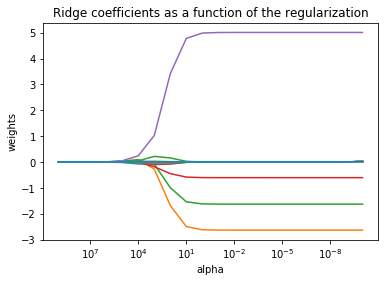

In [20]:
coefs = []
for a in alpha:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X_train, Y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()

ax.plot(alpha, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [21]:
#LassoLARS

from sklearn.linear_model import LassoLarsCV
reg = LassoLarsCV(n_jobs=-1).fit(X_train, Y_train)
print('Coefficient of determination: %f' % reg.score(X_test, Y_test))
print('The best coefficient of regularization: %.10f' % reg.alpha_)

Coefficient of determination: 0.999764
The best coefficient of regularization: 0.0000001863


/home/doa/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


.

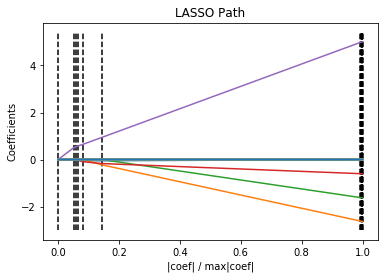

In [22]:
x = X_train.to_numpy(dtype=None, copy=True)
y = Y_train.to_numpy(dtype=None, copy=True)

_, _, coefs = linear_model.lars_path(x, y, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()